## Jupyter Notebook para desarrollar la Task 3

Sistema de recomendación de 5 productos para cada sesión nueva.

Lectura de los DataFrames:

In [1]:
from pathlib import Path    
import pandas as pd

RAW_DATA_PATH = Path('../../data/raw')

train_df = pd.read_csv(         RAW_DATA_PATH / 'train.csv')
test_df = pd.read_csv(          RAW_DATA_PATH / 'test.csv')
products_df = pd.read_pickle(   RAW_DATA_PATH / 'products.pkl')
users_df = pd.read_csv(         RAW_DATA_PATH / 'users_data.csv')

In [2]:
import ast

# Extraer datos del string (JSON) de la columna 'values'
def extract_data_from_string(df, column_name):
    
    df[column_name] = df[column_name].apply(ast.literal_eval)
    
    df['country'] = df[column_name].apply(lambda x: x['country'])
    df['R'] = df[column_name].apply(lambda x: x['R'])
    df['F'] = df[column_name].apply(lambda x: x['F'])
    df['M'] = df[column_name].apply(lambda x: x['M'])
    
    df = df.drop(columns=[column_name])
    
    df = df.explode(['country', 'R', 'F', 'M'])
    
    df['country'] = df['country'].astype(int)
    df['R'] = df['R'].astype(int)
    df['F'] = df['F'].astype(int)
    df['M'] = df['M'].astype(float)
    
    return df

users_df = extract_data_from_string(users_df, 'values')

In [3]:
import pandas as pd
import numpy as np

# Products DataFrame Processing
products_df['discount'] = products_df['discount'].astype(int)
products_df['cod_section'] = products_df['cod_section'].fillna(products_df['cod_section'].median()).astype(int)

# Train DataFrame Processing
train_df['user_id'] = train_df['user_id'].fillna(0).astype(int)
train_df['timestamp_local'] = pd.to_datetime(train_df['timestamp_local'])
train_df['pagetype'] = train_df['pagetype'].fillna(train_df['pagetype'].mode()[0]).astype(int)

test_df['user_id'] = test_df['user_id'].fillna(0).astype(int)
test_df['timestamp_local'] = pd.to_datetime(test_df['timestamp_local'])
test_df['pagetype'] = test_df['pagetype'].fillna(test_df['pagetype'].mode()[0]).astype(int)

# Verify conversions
print("Users DataFrame dtypes:\n", users_df.dtypes)
print("\nTrain DataFrame dtypes:\n", train_df.dtypes)
print("\nTest DataFrame dtypes:\n", test_df.dtypes)
print("\nProducts DataFrame dtypes:\n", products_df.dtypes)

Users DataFrame dtypes:
 user_id      int64
country      int32
R            int32
F            int32
M          float64
dtype: object

Train DataFrame dtypes:
 session_id                  int64
date                       object
timestamp_local    datetime64[ns]
add_to_cart                 int64
user_id                     int32
country                     int64
partnumber                  int64
device_type                 int64
pagetype                    int32
dtype: object

Test DataFrame dtypes:
 session_id                  int64
date                       object
timestamp_local    datetime64[ns]
user_id                     int32
country                     int64
partnumber                  int64
device_type                 int64
pagetype                    int32
dtype: object

Products DataFrame dtypes:
 discount        int32
embedding      object
partnumber      int32
color_id        int32
cod_section     int32
family          int32
dtype: object


In [4]:
# Convertimos las variables a categoricas, nos conviene para que el modelo las interprete como tal
users_df['country'] = users_df['country'].astype('category')

categorical_cols_train = ['device_type', 'pagetype', 'country']
for col in categorical_cols_train:
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')

categorical_cols_products = ['color_id', 'cod_section', 'family']
for col in categorical_cols_products:
    products_df[col] = products_df[col].astype('category')

print("Users DataFrame dtypes:\n", users_df.dtypes)
print("\nTrain DataFrame dtypes:\n", train_df.dtypes)
print("\nTest DataFrame dtypes:\n", test_df.dtypes)
print("\nProducts DataFrame dtypes:\n", products_df.dtypes)

Users DataFrame dtypes:
 user_id       int64
country    category
R             int32
F             int32
M           float64
dtype: object

Train DataFrame dtypes:
 session_id                  int64
date                       object
timestamp_local    datetime64[ns]
add_to_cart                 int64
user_id                     int32
country                  category
partnumber                  int64
device_type              category
pagetype                 category
dtype: object

Test DataFrame dtypes:
 session_id                  int64
date                       object
timestamp_local    datetime64[ns]
user_id                     int32
country                  category
partnumber                  int64
device_type              category
pagetype                 category
dtype: object

Products DataFrame dtypes:
 discount          int32
embedding        object
partnumber        int32
color_id       category
cod_section    category
family         category
dtype: object


In [5]:
# El user_id trae muchos valores nulos, por lo que se nos ocurre crear dos nuevos ids user_id, session_id sin colisiones entre ellos.
# El objetivo es reeplazar los nulos en user_id por el session_id, de forma que si no tenemos el dato de usuario, al menos
#     somos capaces de relacionar registros por sesión (supongamos, por ejemplo que son usuarios no registrados en la web)

# Usamos columnas temporales para crear los nuevos
users_df['temp_user_id'] = users_df['user_id'] * 10
train_df['temp_session_id'] = train_df['session_id'] * 10 + 1
train_df['temp_user_id'] = train_df['user_id'] * 10
test_df['temp_session_id'] = test_df['session_id'] * 10 + 1
test_df['temp_user_id'] = test_df['user_id'] * 10

train_df.loc[train_df['temp_user_id'] == 0, 'temp_user_id'] = train_df.loc[train_df['temp_user_id'] == 0, 'temp_session_id'].astype('int32')
test_df.loc[test_df['temp_user_id'] == 0, 'temp_user_id'] = test_df.loc[test_df['temp_user_id'] == 0, 'temp_session_id'].astype('int32')

users_df['user_id'] = users_df['temp_user_id']
train_df['session_id'] = train_df['temp_session_id']
train_df['user_id'] = train_df['temp_user_id']
test_df['session_id'] = test_df['temp_session_id']
test_df['user_id'] = test_df['temp_user_id']

users_df.drop('temp_user_id', axis=1, inplace=True)
train_df.drop(['temp_session_id', 'temp_user_id'], axis=1, inplace=True)
test_df.drop(['temp_session_id', 'temp_user_id'], axis=1, inplace=True)

# Print, y verificar que no hay colisiones entre los ids.
print(train_df[['session_id', 'user_id']].head())
print(test_df[['session_id', 'user_id']].head())
print(users_df['user_id'].head())

print("\nExisten colisiones:", 
      bool(set(users_df['user_id']).intersection(set(train_df['session_id']))))

   session_id  user_id
0         641      641
1        1171     1171
2        1171     1171
3        5791     5791
4       12201  4807290
   session_id  user_id
0        7461     7461
1        7461     7461
2        7461     7461
3        7461     7461
4        7461     7461
0    1803480
1    1754230
1    1754230
2    1803490
3    1803500
Name: user_id, dtype: int64

Existen colisiones: False


In [6]:
def add_user_features(df: pd.DataFrame) -> pd.DataFrame:
    """Añadimos variables de interés calculadas a nivel de user_id"""
    
    print("Transformamos timestamps...")
    df['total_seconds'] = df['timestamp_local'].astype(np.int64) // 1e9
    df['hour'] = df['timestamp_local'].dt.hour
    
    print("Agrupamos por user_id...")
    grouped = df.groupby('user_id', observed=True).agg({
        'partnumber': 'nunique',
        'pagetype': 'nunique',
        'total_seconds': ['min', 'max'],
        'hour': 'first',
        'user_id': 'size' # Interacciones
    }).reset_index()
    
    grouped.columns = ['user_id', 'unique_products', 'unique_pagetypes', 
                      'min_time', 'max_time', 'first_interaction_hour',
                      'total_interactions']
    
    # Calculamos el tiempo
    grouped['total_user_time'] = (grouped['max_time'] - grouped['min_time']).round(2)
    grouped = grouped.drop(['min_time', 'max_time'], axis=1)
    
    # Merge
    print("Merging results...")
    result = df.merge(grouped, on='user_id')
    
    return result

In [7]:
train_df = add_user_features(train_df)
test_df = add_user_features(test_df)

Transformamos timestamps...
Agrupamos por user_id...
Merging results...
Transformamos timestamps...
Agrupamos por user_id...
Merging results...


In [8]:
# Añadiremos tres columnas, el ratio de exito del usuario con el producto, el ratio de exito global del producto, y el numero de veces que se ha añadido al carrito globalmente cada producto.
user_product_metrics = (
    train_df
    .groupby(['user_id', 'partnumber'])
    .agg({
        'add_to_cart': ['sum', 'count']
    })
    .reset_index()
)

user_product_metrics.columns = ['user_id', 'partnumber', 'adds_to_cart', 'total_visits']
user_product_metrics['success_rate'] = user_product_metrics['adds_to_cart'] / user_product_metrics['total_visits']

train_df = train_df.merge(
    user_product_metrics[['user_id', 'partnumber', 'success_rate']], 
    on=['user_id', 'partnumber'], 
    how='left'
)

product_metrics = (
    train_df
    .groupby('partnumber')
    .agg({
        'add_to_cart': ['sum', 'count']
    })
    .reset_index()
)

product_metrics.columns = ['partnumber', 'total_adds_to_cart', 'total_visits']
product_metrics['global_success_rate'] = product_metrics['total_adds_to_cart'] / product_metrics['total_visits']

products_df = products_df.merge(
    product_metrics[['partnumber', 'total_adds_to_cart', 'global_success_rate']], 
    on='partnumber', 
    how='left'
)

# Cubrimos nulos
train_df['success_rate'] = train_df['success_rate'].fillna(0)
products_df['total_adds_to_cart'] = products_df['total_adds_to_cart'].fillna(0)
products_df['global_success_rate'] = products_df['global_success_rate'].fillna(0)

In [9]:
# Añadimos el historial de usuario
user_history = (
    train_df
    .groupby('user_id')
    .agg(
        avg_success_rate_per_user=('success_rate', 'mean'),
        num_unique_products_interacted=('partnumber', 'nunique')
    )
    .reset_index()
)

users_df = users_df.merge(
    user_history, 
    on='user_id', 
    how='left'
)

# Cubrimos nulos
users_df['avg_success_rate_per_user'] = users_df['avg_success_rate_per_user'].fillna(0)
users_df['num_unique_products_interacted'] = users_df['num_unique_products_interacted'].fillna(0)

In [ ]:
def analyze_dataframes(dfs_dict):
    for name, df in dfs_dict.items():
        print(f"\n{'='*20} {name} Analysis {'='*20}")
        
        print(f"\nShape: {df.shape}")
        print(f"Memory Usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
        
        print("\nColumns and Types:")
        print(df.dtypes)
        
        print("\nMissing Values:")
        print(df.isnull().sum())

        print("\nNumerical Columns Statistics:")
        print(df.describe())
        
        print("\nSample Data:")
        print(df.head())

dfs = {
    'Train': train_df,
    'Test': test_df,
    'Users': users_df,
    'Products': products_df
}

analyze_dataframes(dfs)

## Entrenamiento del modelo: Versión 1

In [10]:
print(train_df.columns)
print(users_df.columns)
print(products_df.columns)

Index(['session_id', 'date', 'timestamp_local', 'add_to_cart', 'user_id',
       'country', 'partnumber', 'device_type', 'pagetype', 'total_seconds',
       'hour', 'unique_products', 'unique_pagetypes', 'first_interaction_hour',
       'total_interactions', 'total_user_time', 'success_rate'],
      dtype='object')
Index(['user_id', 'country', 'R', 'F', 'M', 'avg_success_rate_per_user',
       'num_unique_products_interacted'],
      dtype='object')
Index(['discount', 'embedding', 'partnumber', 'color_id', 'cod_section',
       'family', 'total_adds_to_cart', 'global_success_rate'],
      dtype='object')


In [12]:
import pandas as pd
from lightgbm import LGBMRegressor

def prepare_features(df, users_df, products_df):
    
    # Temporales
    df['hour'] = pd.to_datetime(df['timestamp_local']).dt.hour.astype('int8')

    # Merge de los datasets
    df = df.merge(users_df[['user_id', 'country', 'R', 'F', 'M', 'avg_success_rate_per_user', 'num_unique_products_interacted']], on=['user_id','country'], how='left')
    df = df.merge(products_df[['partnumber', 'discount', 'family', 'color_id', 'cod_section', 'total_adds_to_cart', 'global_success_rate']], on='partnumber', how='left')
    

    features = ['hour', 'country', 'device_type', 'pagetype', 
                'family', 'color_id', 'cod_section', 'total_adds_to_cart', 'global_success_rate', 'avg_success_rate_per_user', 'num_unique_products_interacted',
                'R', 'F', 'M', 'discount', 'total_seconds', 
                'unique_products', 'unique_pagetypes', 'total_interactions', 'total_user_time']

    return df[features]

# Prepare train and test data
X_train = prepare_features(train_df, users_df, products_df)
y_train = train_df['success_rate']
X_test = prepare_features(test_df, users_df, products_df)

print('Entrenando modelo...')

# Entrenamos el modelo
model = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=7,
    random_state=42
)
model.fit(X_train, y_train)

# Prediccion
test_df['predicted_success_rate'] = model.predict(X_test)

Entrenando modelo...


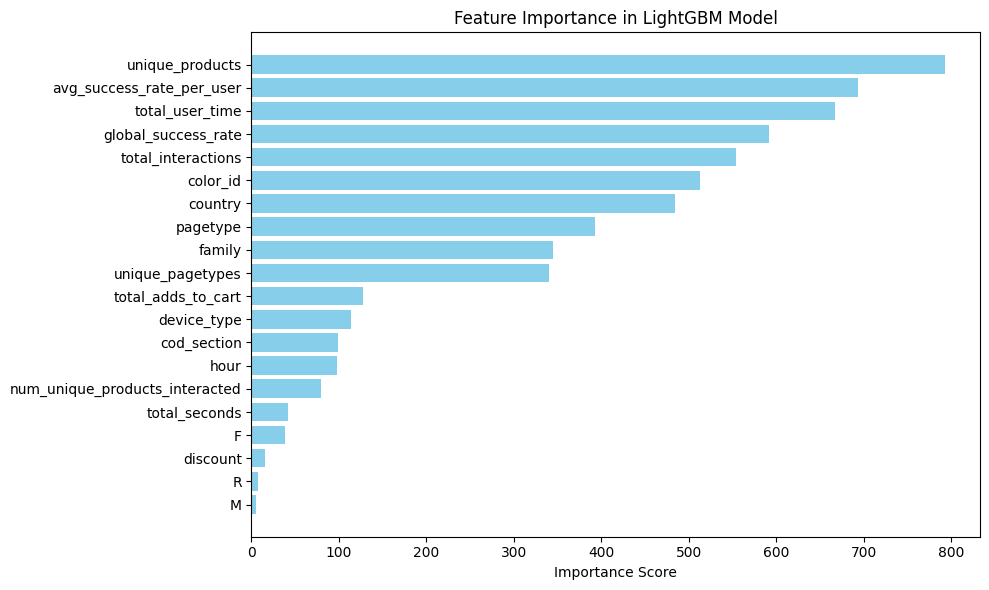

In [46]:
import matplotlib.pyplot as plt

# Get feature importance
feature_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color='skyblue', )
plt.title('Feature Importance in LightGBM Model')
plt.xlabel('Importance Score')
plt.tight_layout()

In [47]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import json
from pathlib import Path

# Productos populares para rellenar recomendaciones
popular_products = (
    products_df
    .sort_values('global_success_rate', ascending=False)
    ['partnumber']
    .tolist()
)

# Enriquecemos test_df con global_success_rate
enriched_test = (
    test_df
    .merge(
        products_df[['partnumber', 'global_success_rate']], 
        on='partnumber', 
        how='left'
    )
)

# Ponderamos entre predicción y popularidad
PREDICTION_WEIGHT = 0.8
GLOBAL_WEIGHT = 0.2

enriched_test['composite_score'] = (
    PREDICTION_WEIGHT * enriched_test['predicted_success_rate'] + 
    GLOBAL_WEIGHT * enriched_test['global_success_rate'].fillna(0)
)

# Generamos las recomendaciones iniciales
recommendations = (
    enriched_test
    .sort_values(['composite_score'], ascending=[False])
    .groupby('session_id')
    .agg({
        'partnumber': lambda x: list(x)
    }) 
)

# Convertimos embeddings de productos en una matriz
products_df['embedding'] = products_df['embedding'].apply(lambda x: x if x is not None else np.zeros(1280))
embedding_matrix = np.vstack(products_df['embedding'].values)

# Calculamos similitudes entre productos
similarity_matrix = cosine_similarity(embedding_matrix)

# Mapeamos cada producto con sus 5 más similares
product_indices = {p: i for i, p in enumerate(products_df['partnumber'])}
product_similarities = {
    partnumber: [
        products_df.iloc[idx]['partnumber'] 
        for idx in np.argsort(-similarity_matrix[product_indices[partnumber]])[1:6]  # Evita el mismo producto (posición 0)
    ]
    for partnumber in products_df['partnumber']
}

#Función para obtener productos similares
def get_similar_products(partnumber, k=3):
    return list(dict.fromkeys(product_similarities.get(partnumber, [])))[:k]

# Función de padding para asegurar 5 recomendaciones únicas
def pad_recommendations(prods):
    prods = list(dict.fromkeys(prods))  # Valores únicos
    
    if len(prods) >= 5:
        return prods[:5]

    # Añadimos productos similares si faltan recomendaciones
    similar_prods = []
    for p in prods:
        similar_prods.extend(get_similar_products(p, k=3))

    combined_prods = list(dict.fromkeys(prods + similar_prods))  # Valores únicos

    if len(combined_prods) >= 5:
        return combined_prods[:5]

    # Rellenamos con productos populares si aún faltan recomendaciones
    remaining = [p for p in popular_products if p not in combined_prods]
    final_recommendations = (combined_prods + remaining)[:5]

    return final_recommendations

result_dict = {
    "target": {
        str(session_id)[:-1]: pad_recommendations(prods)  # Mantiene el flujo correcto
        for session_id, prods in recommendations['partnumber'].items()
    }
}

# Convertimos los valores a int justo antes de guardar el JSON
for session_id in result_dict["target"]:
    result_dict["target"][session_id] = [int(p) for p in result_dict["target"][session_id]]

# Guardar JSON
output_path = Path('../../predictions/predictions_3.json')
output_path.parent.mkdir(parents=True, exist_ok=True)

with open(output_path, 'w') as f:
    json.dump(result_dict, f, indent=4)


## Entrenamiento del modelo: Versión 2

In [ ]:
import pandas as pd
import numpy as np
from implicit.als import AlternatingLeastSquares
from scipy.sparse import coo_matrix
from sklearn.metrics.pairwise import cosine_similarity
import json

# Mapear user_id y partnumber a índices consecutivos
user_mapping = {user: idx for idx, user in enumerate(train_df["user_id"].unique())}
product_mapping = {prod: idx for idx, prod in enumerate(train_df["partnumber"].unique())}

train_df["user_idx"] = train_df["user_id"].map(user_mapping)
train_df["product_idx"] = train_df["partnumber"].map(product_mapping)

# Crear matriz de usuario-producto basada en adiciones al carrito
interaction_matrix = coo_matrix(
    (train_df["add_to_cart"], (train_df["user_idx"], train_df["product_idx"])),
    shape=(len(user_mapping), len(product_mapping))
)

# Convertir la matriz a formato CSR para permitir indexación eficiente
interaction_matrix = interaction_matrix.tocsr()

In [16]:
# Entrenar modelo ALS
als_model = AlternatingLeastSquares(factors=100, regularization=0.1, iterations=20)
als_model.fit(interaction_matrix)

c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 1.3759591579437256 seconds
  warnings.warn(
100%|██████████| 20/20 [03:16<00:00,  9.85s/it]


In [19]:
products_df['embedding'] = products_df['embedding'].apply(lambda x: x if x is not None else np.zeros(1280))

# Convertir a una matriz de NumPy
product_embeddings = np.vstack(products_df["embedding"].values)

# Verificar tamaño
print(f"Shape de embeddings: {product_embeddings.shape}")  # Debería ser (num_productos, 1280)

product_similarity = cosine_similarity(product_embeddings)

Shape de embeddings: (43692, 1280)


In [20]:
# Función para obtener productos similares
def get_similar_products(product_id, top_n=3):
    if product_id not in product_mapping:
        return []
    product_idx = product_mapping[product_id]
    similar_idxs = np.argsort(product_similarity[product_idx])[::-1][1:top_n+1]
    return [list(product_mapping.keys())[i] for i in similar_idxs]

In [35]:
# Generar recomendaciones por session_id
session_ids = test_df["session_id"].unique()
recommendations = {}

# Obtener los productos más populares ordenados por global_success_rate
popular_products = products_df.sort_values(by="global_success_rate", ascending=False)["partnumber"].tolist()

for session in session_ids:
    user = test_df[test_df["session_id"] == session]["user_id"].values[0]

    if user in user_mapping:
        user_idx = user_mapping[user]

        # Obtener recomendaciones para este usuario
        recs = als_model.recommend(user_idx, interaction_matrix[user_idx], N=5)
        recommended_products = [list(product_mapping.keys())[int(i[0])] for i in recs]

        # Asegurar que cada session_id tenga 5 productos
        recommended_products = list(set(recommended_products))  # Eliminar duplicados si los hay
        while len(recommended_products) < 5:
            for popular in popular_products:
                if popular not in recommended_products:
                    recommended_products.append(popular)
                if len(recommended_products) == 5:
                    break  # Detener cuando tengamos 5 recomendaciones

        recommendations[session] = recommended_products

In [36]:
# Convertir session_id a string y product IDs a int
recommendations = {
    str(session)[:-1]: [int(product) for product in products] 
    for session, products in recommendations.items()
}

# Guardar JSON
output_path = Path('../../predictions/predictions_3.json')
output_path.parent.mkdir(parents=True, exist_ok=True)

with open(output_path, "w") as f:
    json.dump({"target": recommendations}, f, indent=4)

print("Recomendaciones generadas en predictions_3.json")

Recomendaciones generadas en predictions_3.json
